# Contents

1. Components
2. Google Sheets to Python via API
3. Connection to Redshift
4. Query on existing data and warm up
5. Drop the existing pharmacy table, create a new table and repopulate

# 1.  Components

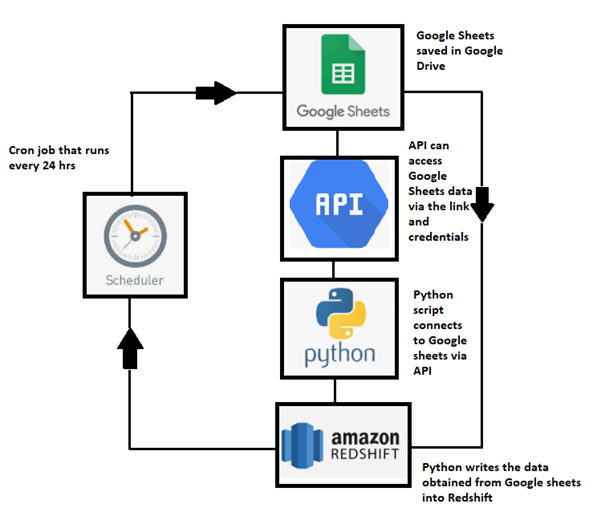

## Steps 

1. The Account manager may have a Google Sheet with him, in which he may update all the information corresponding to the pharmacies. This sheet is present in the Google Drive.
2. The Google Sheet data can be extracted via API script that is written in a Python file. The data is processed for the next step (converted into a dataframe, which is a form of table used for data operations in Python). Documentation available: https://developers.google.com/sheets/api/quickstart/python
3. A connection is made with Redshift using the server end point and the user credentials, database name and port number. Documentation available: 
https://docs.aws.amazon.com/redshift/latest/mgmt/python-connect-examples.html
4. A table is created in the Redshift and all the data from the dataframe is inserted into redshift. The table reflects the exact data present in google sheets. Python also gives us a lot of flexibility with transforming the data that includes creating new fields, etc. 
5. This .py file can be used in a cron job, that will run run every 24 hours. In each run the existing table will be deleted and the table will be created again and the exact data present in Google sheets will be loaded again. 


# 2. Google Sheets to Python via API

In [5]:
from __future__ import print_function

import os.path

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import pandas as pd

# If modifying these scopes, delete the file token.json.
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

# The ID and range of a sample spreadsheet.
SAMPLE_SPREADSHEET_ID = '1sPbID8r37mnniY-VTtU_fD9LNsdgEU-6tUiJtS6ALc4'

SAMPLE_RANGE_NAME = 'Sheet1'

"""Shows basic usage of the Sheets API.
Prints values from a sample spreadsheet.
"""
creds = None
    # The file token.json stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
if os.path.exists('token.json'):
    creds = Credentials.from_authorized_user_file('token.json', SCOPES)
    # If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
                'client_secret_99150136979-i0e25ioc2e5qqrum170dpuq8o8seo748.apps.googleusercontent.com.json', SCOPES)
        creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
    with open('token.json', 'w') as token:
        token.write(creds.to_json())

try:
    service = build('sheets', 'v4', credentials=creds)

        # Call the Sheets API
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                    range=SAMPLE_RANGE_NAME).execute()
    values = result.get('values', [])

    if not values:
        print('No data found.')

except HttpError as err:
    print(err)
    
headers = values.pop(0) # gives the headers as list and leaves data
df = pd.DataFrame(values, columns=headers)
df

,col1,col2
0,0.2396834418,0.4499586249
1,0.1867528551,0.2321058953
2,0.09454747254,0.6179074466
3,0.08471842899,0.2710999652
4,0.6429797093,0.7649840848
5,0.1322202476,0.530392196
6,0.4235440278,0.7942029389
7,0.1709353753,0.755968175
8,0.6457071774,0.02455718969
9,0.8368530224,0.8768026318


# 3. Connection to Redshift

In [6]:
import redshift_connector
conn = redshift_connector.connect(
     host='redshift-cluster-1.camozuuyali3.us-east-2.redshift.amazonaws.com',
    
    #:5439/dev
     database='dev',
     port = 5439,
     user='awsuser',
     password='November=2017'
  )

# 4. Query on existing data and warm-up

In [7]:
cursor = conn.cursor()
cursor.execute("select * from users limit 100")
result: tuple = cursor.fetchall()
print(result)

([2, 'PGL08LJI', 'Vladimir', 'Humphrey', 'Murfreesboro', 'SK', 'Suspendisse.tristique@nonnisiAenean.edu', '(783) 492-1886', None, None, None, True, True, None, None, True, False, True], [4, 'XDZ38RDD', 'Barry', 'Roy', 'Omaha', 'AB', 'sed@lacusUtnec.ca', '(355) 452-8168', False, True, None, False, None, None, None, None, None, False], [5, 'AEB55QTM', 'Reagan', 'Hodge', 'Forest Lake', 'NS', 'Cum@accumsan.com', '(476) 519-9131', None, None, True, False, None, None, True, True, False, True], [7, 'OWY35QYB', 'Tamekah', 'Juarez', 'Moultrie', 'WV', 'elementum@semperpretiumneque.ca', '(297) 875-7247', None, None, None, True, True, False, None, None, False, False], [9, 'MSD36KVR', 'Mufutau', 'Watkins', 'Port Orford', 'MD', 'Integer.mollis.Integer@tristiquealiquet.org', '(725) 719-7670', True, False, None, False, True, None, None, None, False, True], [10, 'WKW41AIW', 'Naida', 'Calderon', 'Waterbury', 'MB', 'Donec.fringilla@sodalesat.org', '(197) 726-8249', False, False, False, None, False, True,

# 4. Drop the existing pharmacy table, create a new table and repopulate

In [8]:
cursor = conn.cursor() 
cursor.execute("drop table if exists pharmacy_accounts")

create_pharmacy_accounts = '''create table pharmacy_accounts (

col1 float,
col2 float

)'''

cursor.execute(create_pharmacy_accounts)

for index, row in df.iterrows():
    query = "insert into pharmacy_accounts values ({}, {});".format(row['col1'], row['col2'])
    cursor.execute(query)

cursor.execute('select * from pharmacy_accounts')
result: tuple = cursor.fetchall()
print(result)

([0.2396834418, 0.4499586249], [0.1867528551, 0.2321058953], [0.09454747254, 0.6179074466], [0.08471842899, 0.2710999652], [0.6429797093, 0.7649840848], [0.1322202476, 0.530392196], [0.4235440278, 0.7942029389], [0.1709353753, 0.755968175], [0.6457071774, 0.02455718969], [0.8368530224, 0.8768026318], [0.8883313124, 0.5757890278], [0.1226877969, 0.4838938503], [0.7554839312, 0.4185476075], [0.2276504672, 0.01954632425], [0.7553977763, 0.9672395277], [0.3304281555, 0.2503904193], [0.9951071225, 0.5227661459], [0.9544070836, 0.0869916398], [0.3618058463, 0.2910961092], [0.3710640636, 0.595616603], [0.1472908811, 0.6328757714], [0.7985975392, 0.2493439462], [0.2262834467, 0.2533170981], [0.1714041954, 0.3952157])
